In [18]:
%matplotlib inline

(modified SimPEG example)

# Linear Least-Squares Inversion

Here we demonstrate the basics of inverting data with SimPEG by considering a
linear inverse problem. We formulate the inverse problem as a least-squares
optimization problem. For this tutorial, we focus on the following:

    - Defining the forward problem
    - Defining the inverse problem (data misfit, regularization, optimization)
    - Specifying directives for the inversion
    - Recovering a set of model parameters which explains the observations


## Import Modules




In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from wbi import wavelet_regularization as wav_reg
importlib.reload(wav_reg)
from discretize import TensorMesh

from SimPEG import (
    simulation,
    maps,
    data_misfit,
    optimization,
    regularization,
    inverse_problem,
    inversion,
)

# sphinx_gallery_thumbnail_number = 3

## Defining the Model and Mapping

Here we generate a synthetic model and a mappig which goes from the model
space to the row space of our linear operator.




(-2.0, 2.0)

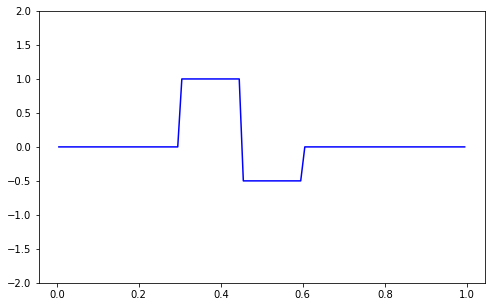

In [2]:
nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.vectorCCx > 0.3] = 1.0
true_model[mesh.vectorCCx > 0.45] = -0.5
true_model[mesh.vectorCCx > 0.6] = 0

# Mapping from the model space to the row space of the linear operator
model_map = maps.IdentityMap(mesh)

# Plotting the true model
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(mesh.vectorCCx, true_model, "b-")
ax.set_ylim([-2, 2])

## Defining the Linear Operator

Here we define the linear operator with dimensions (nData, nParam). In practive,
you may have a problem-specific linear operator which you would like to construct
or load here.




Text(0.5, 1.0, 'Columns of matrix G')

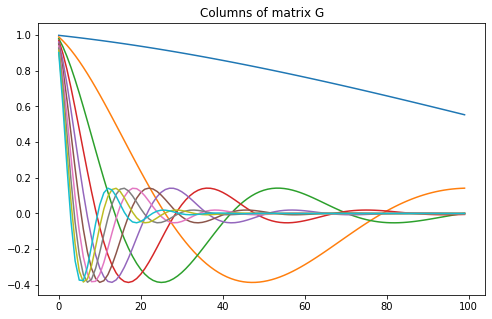

In [3]:
# Number of data observations (rows)
nData = 10

# Create the linear operator for the tutorial. The columns of the linear operator
# represents a set of decaying and oscillating functions.
jk = np.linspace(1.0, 60.0, nData)
p = -0.25
q = 0.25


def g(k):
    return np.exp(p * jk[k] * mesh.vectorCCx) * np.cos(
        np.pi * q * jk[k] * mesh.vectorCCx
    )


G = np.empty((nData, nParam))

for i in range(nData):
    G[i, :] = g(i)

# Plot the columns of G
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(G.shape[0]):
    ax.plot(G[i, :])

ax.set_title("Columns of matrix G")

## Defining the Simulation

The simulation defines the relationship between the model parameters and
predicted data.




In [4]:
sim = simulation.LinearSimulation(mesh, G=G, model_map=model_map)

c:\users\u0102388\pyprojects\wavelet-based-inversion\venv\lib\site-packages\SimPEG\simulation.py:547: UserWarning: G has not been implemented for the simulation
  warnings.warn("G has not been implemented for the simulation")


## Predict Synthetic Data

Here, we use the true model to create synthetic data which we will subsequently
invert.




In [5]:
# Standard deviation of Gaussian noise being added
std = 0.1
np.random.seed(1)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, relative_error=std, add_noise=False)

## Define the Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem




In [6]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_obj)

# Define the regularization (model objective function).
# reg = regularization.SimpleSmoothDeriv(mesh)
# reg.mref=np.zeros(nParam)
reg = wav_reg.WaveletRegularization1D(mesh,)

# Define how the optimization problem is solved.
opt = optimization.BFGS(maxIter=50,LSshorten=0.1, maxStep=0.5)


# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
inv_prob.phi_d = np.nan
inv_prob.phi_m = np.nan
inv_prob.beta = 0

## Setting a Starting Model and Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [7]:
inv = inversion.BaseInversion(inv_prob)

# Starting model
starting_model = np.random.rand(nParam)
starting_model = np.zeros(nParam)


# The inversion class is kinda broken
# Run inversion
recovered_model = inv.run(starting_model)


SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
==================================== BFGS ====================================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  5.00e+02  4.28e-03  5.00e+02    2.18e+04      0              
   1  0.00e+00  4.25e+02  1.09e-01  4.25e+02    8.48e+03      1              
   2  0.00e+00  4.23e+02  9.79e-02  4.23e+02    6.25e+03      2              
------------------------------------------------------------------
0 :    ft     = 4.2283e+02 <= alp*descent     = 4.2283e+02
1 : maxIterLS =      10    <= iterLS          =     10
------------------------- End Linesearch -------------------------
The linesearch got broken. Boo.


## Quick and dirty fix for SimPEG "issue"

### L-curve


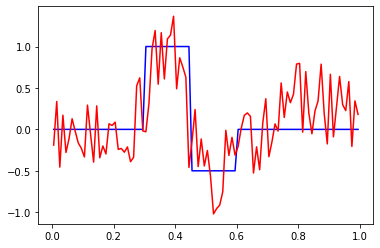

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_RED

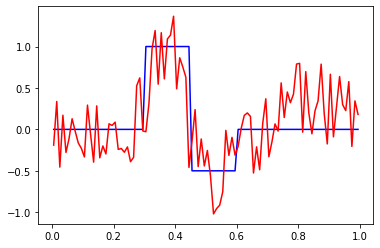

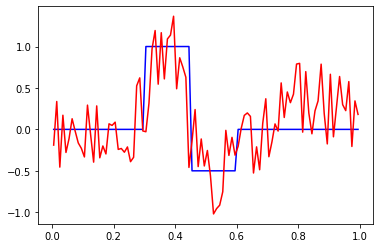

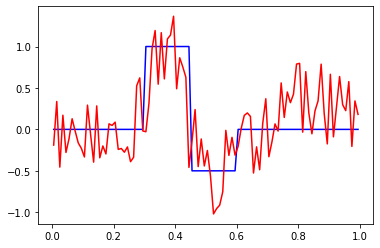

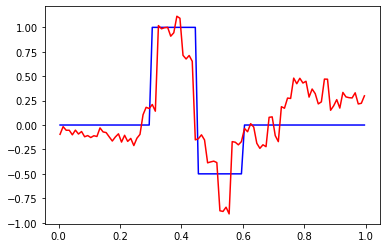

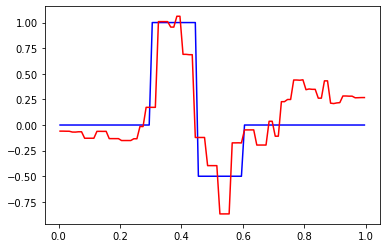

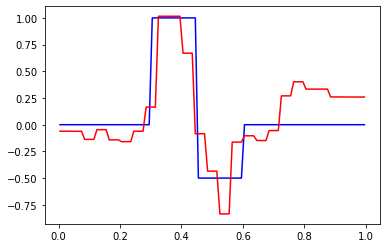

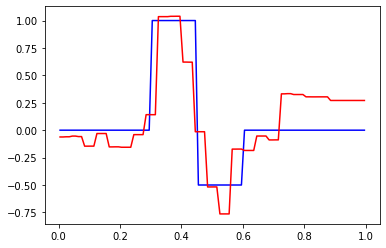

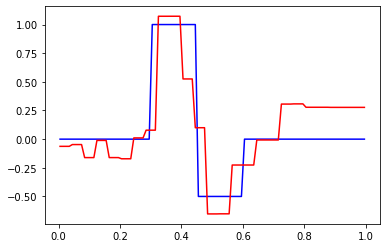

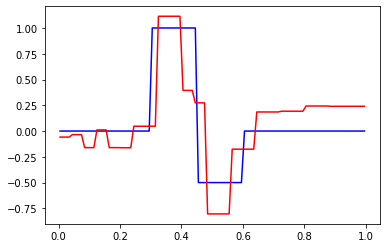

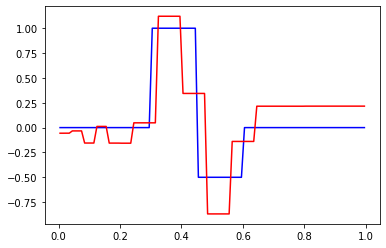

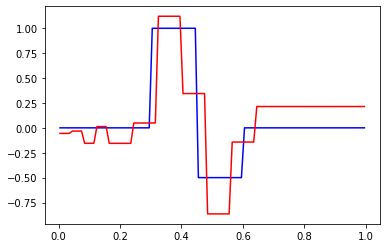

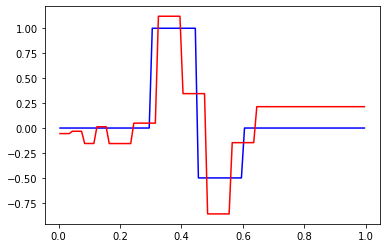

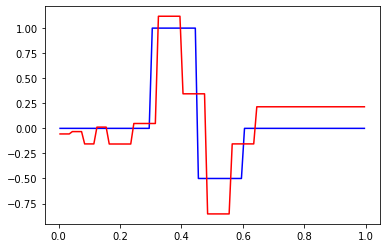

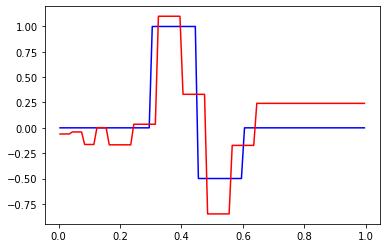

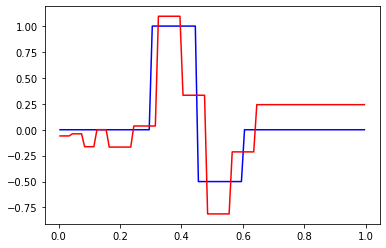

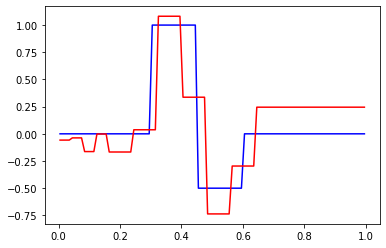

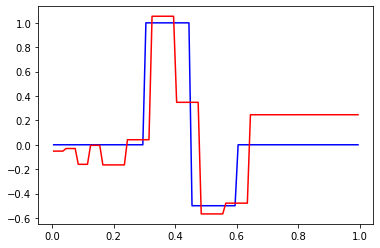

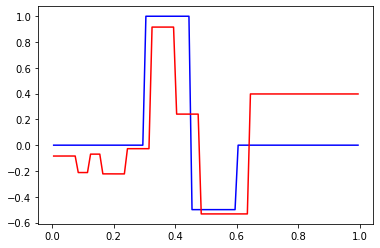

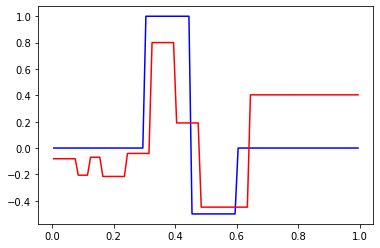

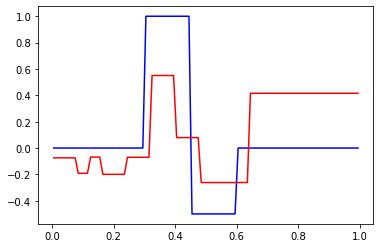

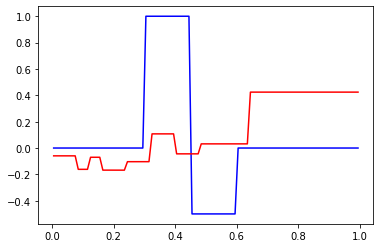

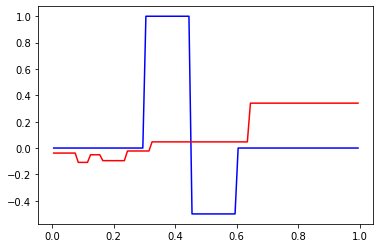

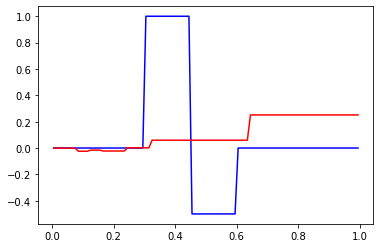

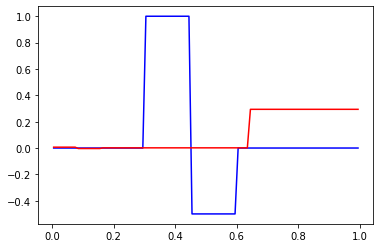

In [8]:
np.random.seed(5)
starting_model = np.random.rand(nParam)
phil = []
phi_d = []
phi_m = []
betalist = np.logspace(-4,4,25)
for beta in betalist:

    def phi(m):
        return dmis(m) + beta*reg(m)

    def jac(m):
        return np.squeeze(dmis.deriv(m) + beta*reg.deriv(m))

    def hess(m,v):
        return dmis.deriv2(m, v=v) + beta*reg.deriv2(m)*v

    x = minimize(phi, starting_model, args=(), method='L-BFGS-B', jac=jac, bounds=None, tol=1e-9, )

    plt.figure()
    plt.plot(mesh.vectorCCx, true_model, "b-")
    plt.plot(mesh.vectorCCx, x.x, "r-")
    plt.show()
    
    print(x.message)
    
    phil.append(phi(x.x))
    phi_d.append(dmis(x.x))
    phi_m.append(reg(x.x))


Text(0.5, 1.0, 'L-curve')

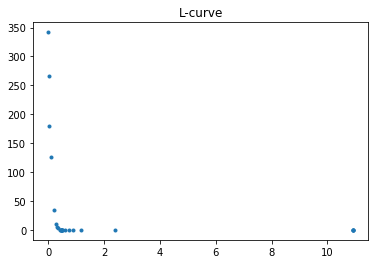

In [67]:
plt.plot(phi_m, phi_d,'.')
plt.title('L-curve')